## <使い方>



In [13]:
%%shell

cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF


apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg


cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

apt-get update
apt-get install chromium chromium-driver

pip install selenium
pip install japanize-matplotlib

chromium --version
chromedriver --version

Executing: /tmp/apt-key-gpghome.HMlzvD7ATQ/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.wtNu9JSxZk/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Executing: /tmp/apt-key-gpghome.xsYgGBjkk6/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
gpg: cannot open '/dev/tty': No such device or address
gpg: [stdout]: write error: Broken pipe
gpg: filter_flush failed on c

In [14]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import os
import time
from selenium.webdriver.support.select import Select
import pandas as pd
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools
import shutil

In [15]:
# ブラウザをheadlessモード実行
options = webdriver.ChromeOptions()
#ヘッドレスモード（バックグラウンドで起動）で実行。コラボの場合、必須。
options.add_argument('--headless')
#サンドボックスモードの解除。これも必須。
options.add_argument('--no-sandbox')
#これも設定した方がよい。
options.add_argument('--disable-dev-shm-usage')
#ファイルダウンロードフォルダを指定
download_path = '/tmp'
options.add_experimental_option("prefs", {"download.default_directory": download_path})

In [16]:
service = Service(executable_path=r'/usr/bin/chromedriver')
driver = webdriver.Chrome(service=service, options=options)
driver.implicitly_wait(60)

In [17]:
## WEALTH ADVISORの投資信託ID

TRUST_IDS = ['2018103105', '2017022702','201707310D']
FUND_DICT = {}

shutil.rmtree(download_path)

#urlの指定

for trust_id in TRUST_IDS:
  url="https://www.wealthadvisor.co.jp/FundData/Download.do?fnc=" + trust_id
  driver.get(url)

  fundname = driver.find_element(By.XPATH, '//div[@class="fundnamea"]/h1').text
  FUND_DICT.update({trust_id: fundname})


  select_elm = driver.find_element(By.XPATH, '//select[@name="selectStdYearFrom"]')
  select_obj = Select(select_elm)
  select_obj.select_by_index(0)

  select_elm = driver.find_element(By.XPATH, '//select[@name="selectStdMonthFrom"]')
  select_obj = Select(select_elm)
  select_obj.select_by_index(0)

  select_elm = driver.find_element(By.XPATH, '//select[@name="selectStdDayFrom"]')
  select_obj = Select(select_elm)
  select_obj.select_by_index(0)

  select_elm = driver.find_element(By.XPATH, '//select[@name="selectStdYearTo"]')
  select_obj = Select(select_elm)
  select_obj.select_by_index(len(select_obj.options) - 1)

  select_elm = driver.find_element(By.XPATH, '//select[@name="selectStdMonthTo"]')
  select_obj = Select(select_elm)
  select_obj.select_by_index(len(select_obj.options) - 1)

  select_elm = driver.find_element(By.XPATH, '//select[@name="selectStdDayTo"]')
  select_obj = Select(select_elm)
  select_obj.select_by_index(len(select_obj.options) - 1)

  driver.find_element(By.XPATH, '//p[@class="mt10"]/input').click()

  time.sleep(5)
  os.rename(download_path + "/DownloadStdYmd.do", download_path + "/" + trust_id + ".csv")

print(FUND_DICT)

{'2018103105': 'eMAXIS Slim全世界株式(オール･カントリー)', '2017022702': 'eMAXIS Slim先進国債券インデックス', '201707310D': 'ゴールド･ファンド(H無)'}


#### CSVファイル読み込み

In [18]:
files = glob.glob(download_path + "/*.csv")
now = datetime.datetime.now()
now_str = now.strftime('%Y-%m-%d')


concat_df = pd.DataFrame(columns=['Date'])
concat_df['Date'] = pd.date_range('2018-01-01', now_str, freq='D')

for id in TRUST_IDS:
  df = pd.read_csv(os.path.join(download_path, id + '.csv'), header=0, names=['Date', id], encoding="shift-jis")

  df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y-%m-%d')

  concat_df = concat_df.merge(df, on='Date')

concat_df = concat_df.set_index('Date')

concat_df

,2018103105,2017022702,201707310D
Date,,,
2018-10-31,10000,10370,9797
2018-11-01,10077,10313,9705
2018-11-02,10209,10369,9837
2018-11-05,10228,10378,9868
2018-11-06,10259,10395,9849
...,...,...,...
2023-11-13,20421,12847,19958
2023-11-14,20466,12860,20079
2023-11-15,20732,12976,20109


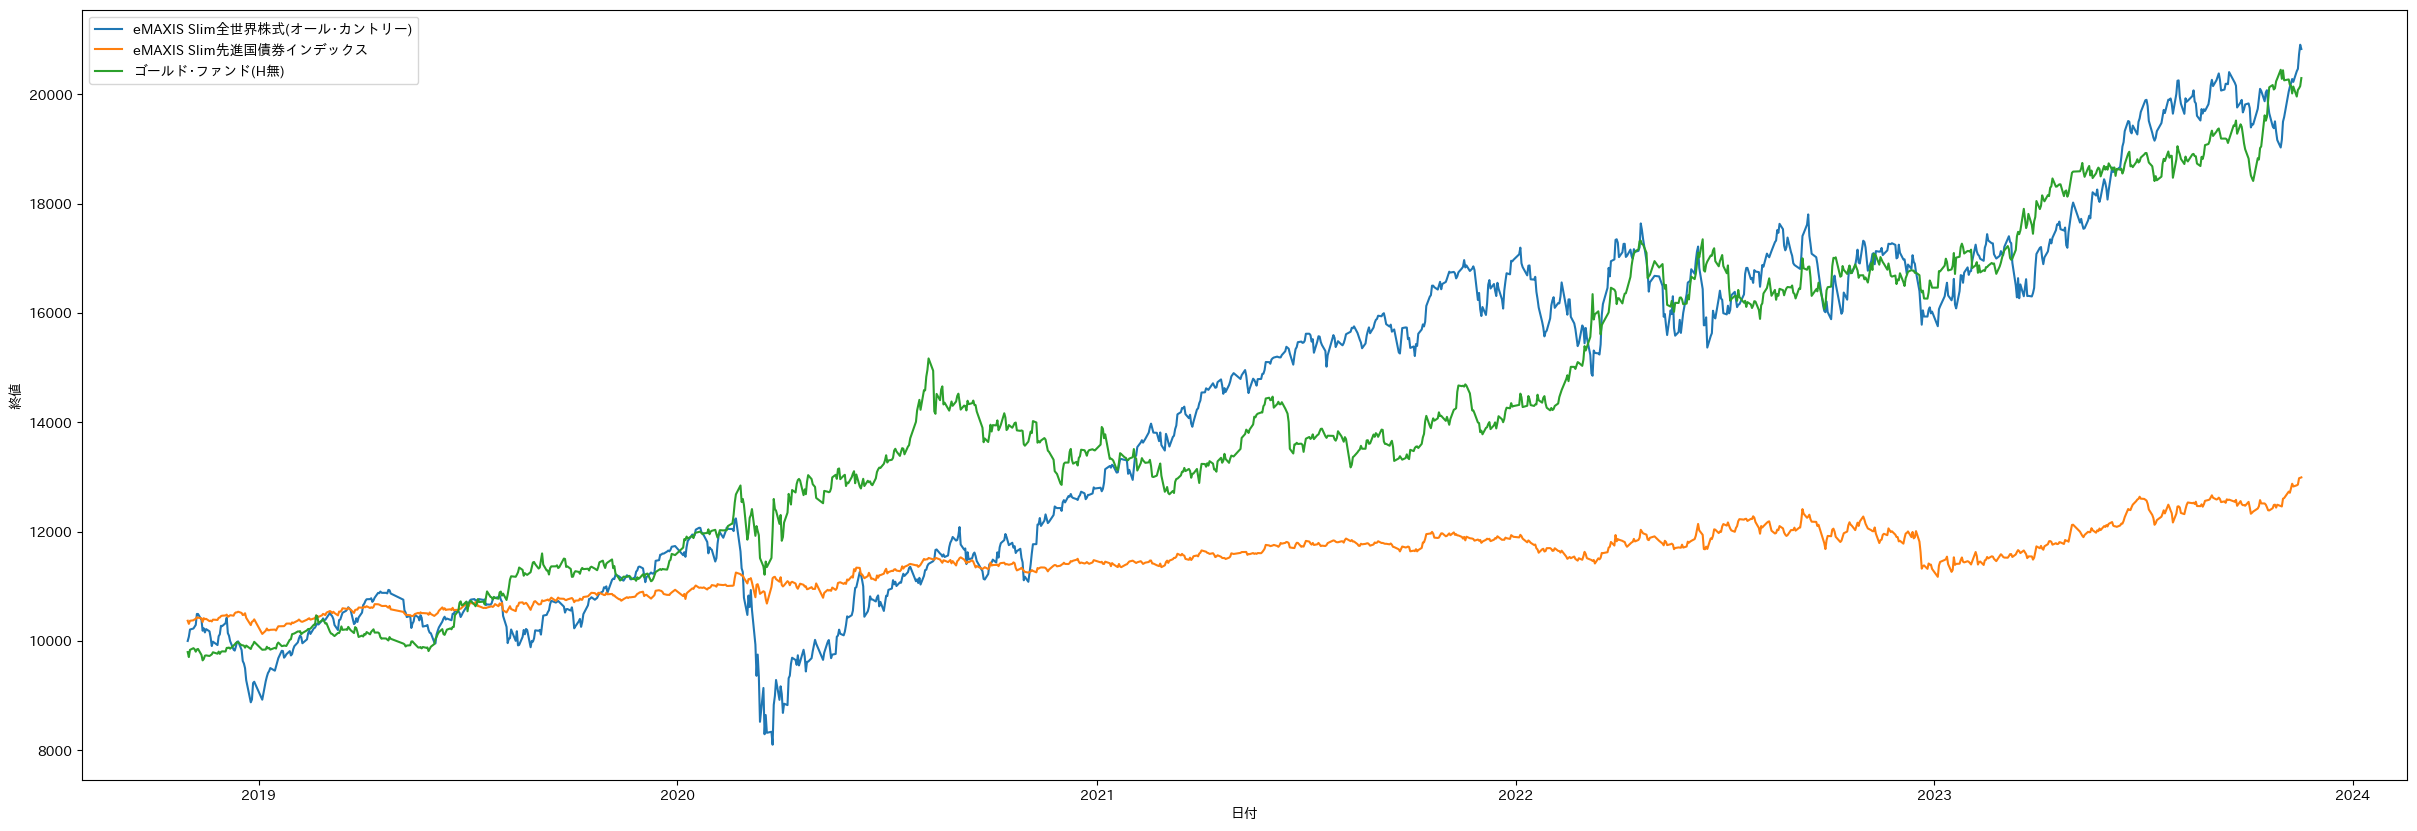

In [19]:
plt.figure(figsize=(30, 10))
for trust_id in TRUST_IDS:
  plt.plot(concat_df.index,concat_df[trust_id] , label=FUND_DICT[trust_id])
plt.xlabel("日付")
plt.ylabel("終値")
plt.legend()
plt.show()

#### 対数収益率

$$
log(Pt/Pt-1)
$$

In [20]:
for trust_id in TRUST_IDS:
  concat_df[trust_id] = np.log(concat_df[trust_id] / concat_df[trust_id].shift(1))
concat_df

,2018103105,2017022702,201707310D
Date,,,
2018-10-31,NaN,NaN,NaN
2018-11-01,0.007671,-0.005512,-0.009435
2018-11-02,0.013014,0.005415,0.013510
2018-11-05,0.001859,0.000868,0.003146
2018-11-06,0.003026,0.001637,-0.001927
...,...,...,...
2023-11-13,0.009595,0.001714,-0.009127
2023-11-14,0.002201,0.001011,0.006044
2023-11-15,0.012913,0.008980,0.001493


#### 標準偏差
https://www.nomura.co.jp/terms/japan/hi/A02397.html#:~:text=%E6%A8%99%E6%BA%96%E5%81%8F%E5%B7%AE%E3%81%AF%E6%B1%82%E3%82%81%E3%81%9F,%E5%B9%B4%E7%8E%87%E6%8F%9B%E7%AE%97%E5%80%A4%E3%81%AB%E3%81%AA%E3%82%8B%E3%80%82

In [21]:
# 個別の年間標準偏差
for trust_id in TRUST_IDS:
  print(FUND_DICT[trust_id] + " : " + str(round(concat_df[trust_id].std() * 250 ** 0.5, 5) * 100) + ' %')

eMAXIS Slim全世界株式(オール･カントリー) : 20.008 %
eMAXIS Slim先進国債券インデックス : 7.432999999999999 %
ゴールド･ファンド(H無) : 13.846 %


##### ポートフォリオのリスク計算


In [22]:
port_weights = []
port_return = []
port_risk = []
sharpe_ratio = []

for r in range(10000):
  weight = np.random.random(len(TRUST_IDS))
  weight = weight/np.sum(weight)

  port_weights.append(weight)

  # リターン計算
  port_return.append(np.dot((concat_df.mean() * 250), weight))

  # ボラティリティ計算
  port_risk.append((np.dot(weight.T, np.dot(concat_df.cov() * 250, weight))) ** 0.5)


  # シャープレシオ
  sharpe_ratio.append(port_return[r]/port_risk[r])

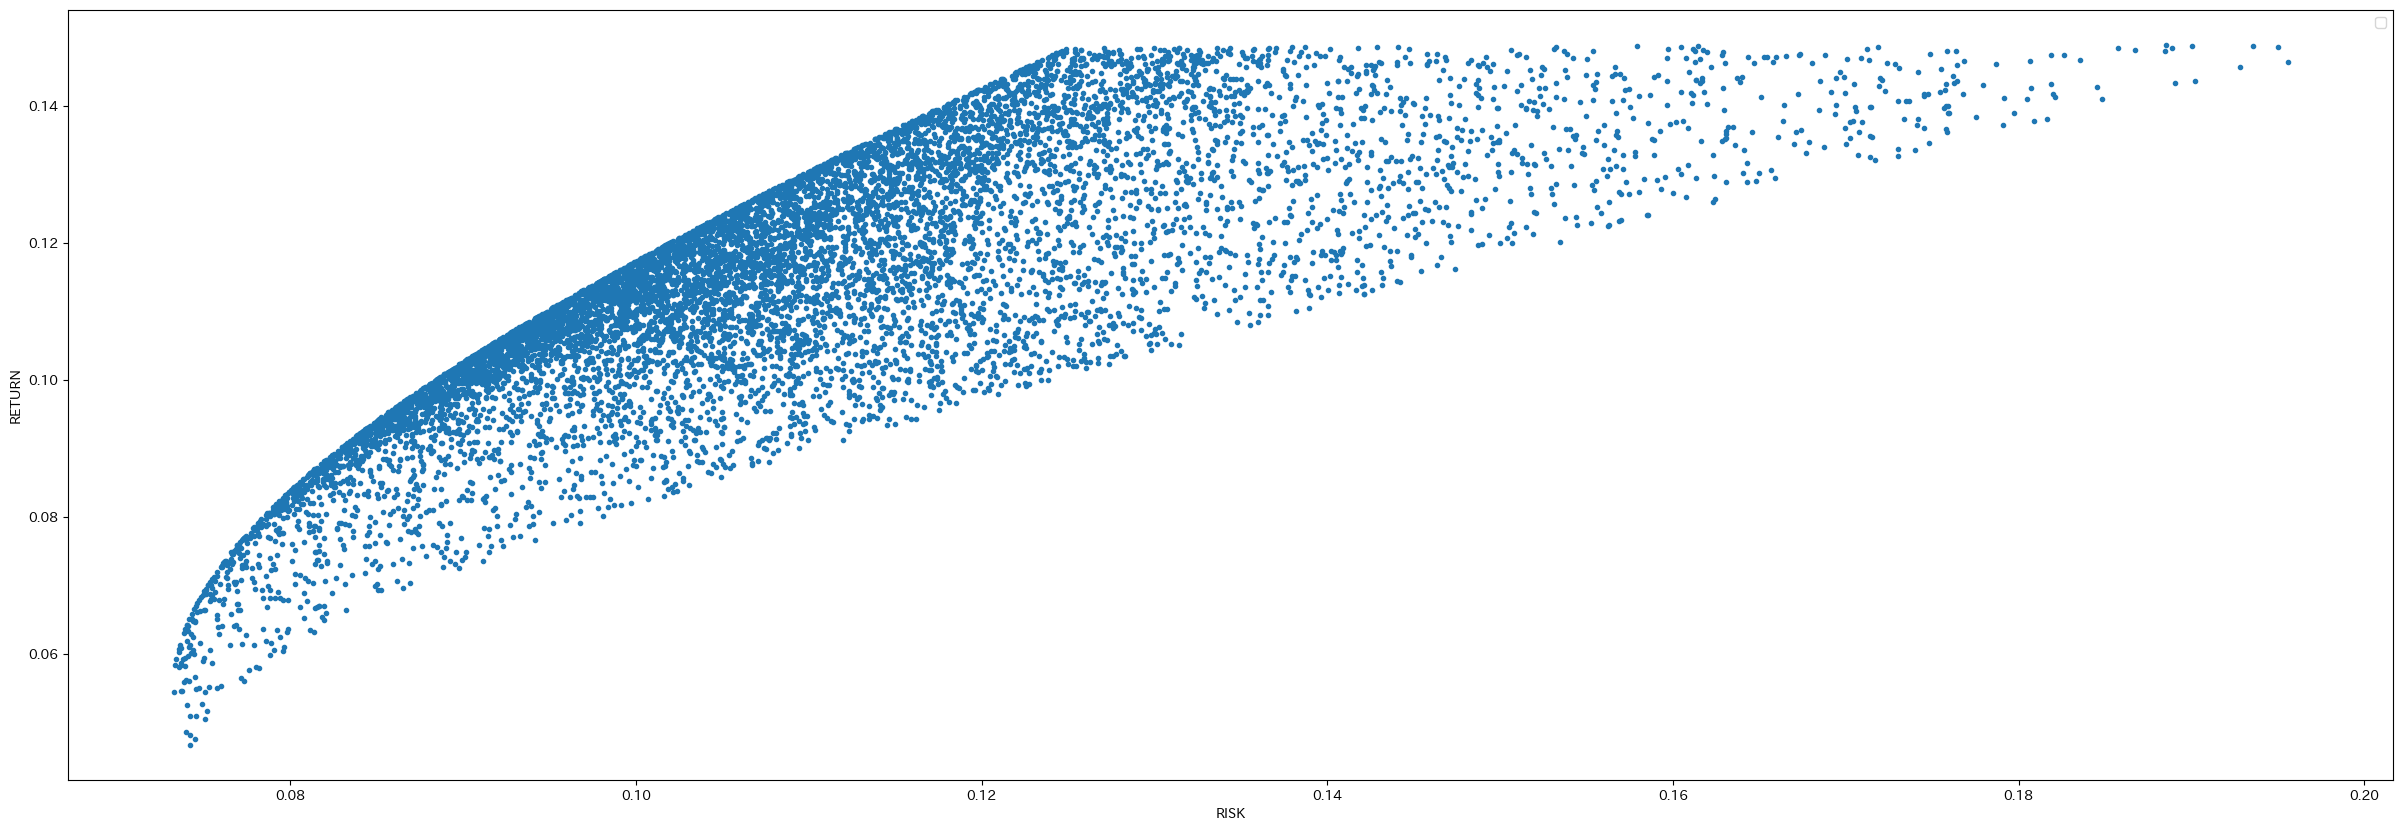

In [23]:
# 効率的なフロンティアを表にプロットする。
%matplotlib inline
plt.figure(figsize=(30, 10))
plt.plot(port_risk, port_return, '.' )
plt.xlabel('RISK')
plt.ylabel('RETURN')
plt.legend()
plt.show()

In [24]:
#サマリではなく全行表示させたい場合は以下Optionをコメントインする。
pd.set_option('display.max_rows', 100)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

result_df = pd.DataFrame({'RISK': port_risk,
                          'RETURN': port_return,
                          'SHARP_RATIO': sharpe_ratio})
for w,id in zip(np.array(port_weights).T,TRUST_IDS):
  result_df[FUND_DICT[id]] = w
# シャープレシオでソート
#result_df.sort_values(by=['SHARP_RATIO'], ascending=True)

# 年間リスク8% リターン15% の場合の投資比率を一覧表で表示する。
result_df[(result_df['RETURN'] <= 0.15) &
          (result_df['RETURN'] >= 0.08)].sort_values(by=['SHARP_RATIO'])

#result_df[(result_df['RETURN'] <= 0.07) &
#          (result_df['RETURN'] >= 0.05) &
#          (result_df['RISK'] < 0.08)].sort_values(by=['RETURN','RISK'], ascending=[True,False])


#result_df.sort_values('RETURN')

,RISK,RETURN,SHARP_RATIO,eMAXIS Slim全世界株式(オール･カントリー),eMAXIS Slim先進国債券インデックス,ゴールド･ファンド(H無)
9498,0.195565,0.146481,0.749016,0.973190,0.025614,0.001195
9504,0.190218,0.143586,0.754849,0.941328,0.053595,0.005078
6164,0.192792,0.145678,0.755623,0.956680,0.033291,0.010029
6835,0.189042,0.143410,0.758615,0.934292,0.055245,0.010463
3859,0.181644,0.138048,0.759989,0.889876,0.107227,0.002897
...,...,...,...,...,...,...
71,0.117149,0.139233,1.188509,0.249286,0.088797,0.661916
1631,0.120754,0.143521,1.188536,0.265156,0.047021,0.687824
3618,0.118067,0.140330,1.188561,0.256608,0.078141,0.665251
9167,0.118037,0.140296,1.188578,0.254258,0.078454,0.667288
